## Резюме по домашнему заданию
В качестве набора данных для построения модели был выбран датасет с оттоком клиентов (https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data). Требуется построить классификатор на основе градиентного бустинга, предсказывающий отток клиента. Конкретной целевой метрики качества в условии задачи не указано, бизнес-контекста тоже нет. Поэтому выбираю метрику на свое усмотрение. Промежуточные выводы и доп. информация записаны в комментариях в ячейках. Визуализация распределений, зависимостей, метрик и прочего - в коде ниже
#### EDA
- Много категориальных признаков. Признаки с двумя значениями преобразованы в бинарные {0, 1}. Остальные закодированы через LabelEncoding, как указано в задании
- Исправлены некорректные записи в данных. Например, в числовом признаке TotalCharges присутствует значение ' ' (заменили его на 0 согласно описанию данных)
- Визуализированы распределения признаков и зависимость таргета от них
- <b>В данных наблюдается дисбаланс классов: ~27% положительного класса</b>
#### Построение модели
- Поскольку в данных наблюдается дисбаланс классов, а бизнес-контекста к задаче не дается, <b>метрикой качества я выбрал ROC-AUC</b>: она удобна при несбалансированных данных и демонстрирует ранжирующую силу модели, что является универсальной характеристикой. <b>Дополнительно посмотрим на стандартные метрики: accuracy, recall, precision, f1-score + PR-AUC</b>
- Построены модели на основе реализаций бустинга в sklearn, XGBoost, CatBoost и LightGBM с дефолтными гиперпараметрами. Явного лидера нет, но есть явный аутсайдер - XGBoost c ROC-AUC ~ 0.84. У остальных ~ 0.85
- Затем были построены эти же модели, но с гиперпараметрами, подобранными с помощью GridSearch (подбирались n_estimators, max_depth и subsample). В итоге получились практически одинаковые по качеству модели (размах между ними < 0.005) - визуализация приведена в коде ниже. Но технически наибольшее качество дала <b>CatBoost с {'max_depth': 2, 'n_estimators': 100, 'subsample': 0.9}</b>: <b>ROC-AUC ~ 0.86</b>, поэтому для дальнейшей работы была выбрана она. А такой ROC-AUC считается вполне хорошим
- Дополнительно была предпринята попытка подобрать гиперпараметры с помощью optuna - значимого прироста в качестве она не дала. Она нашла гиперпараметры, дающие то же качество, ощутимо быстрее, однако - с заметно большим количеством деревьев, что делает модель вычислительно менее эффективной
#### Анализ модели
- Анализ feature_importance позволил избавиться от половины признаков без потери качества
- Полученная модель показывает <b>accuracy = 0.81 и precision = 0.69, recall = 0.52, f1-score = 0.59 на миноритарном классе</b> (на мажоритарном намного лучше, но он нас в этой ситуации не интересует). Варьирование порога предсказания может изменить эти метрики, но улучшения какой-то метрики без существенного ухудшения другой ожидать не приходится
- <b>PR-AUC ~ 0.69</b>, что, кажется, не так уж плохо при дисбалансе классов с долей миноритарного ~ 27%
#### Результат
<b>Данные несбалансированы: доля положительного класса ~27%. В качестве метрики качества выбран ROC-AUC. Лучшей модели "из коробки" нет (есть худшая - XGBoost). После настройки гиперпараметров все модели выравнялись в качестве: разница незначима, но выбрал ту, которая технически дала лучший результат - CatBoost с {'max_depth': 2, 'n_estimators': 100, 'subsample': 0.9}. Она показывает следующие значения метрик: 
<br>ROC-AUC ~ 0.86,
<br>PR-AUC ~ 0.69,
<br>precision = 0.69 на миноритарном классе, 
<br>recall = 0.52 на миноритарном классе, 
<br>f1-score = 0.59 на миноритарном классе, 
<br>accuracy = 0.81.
<br>Это существенно лучше, чем у случайного классификатора, который дает ROC-AUC = 0.5 и PR-AUC = 0.27, и чем у константного классификатора, предсказывающего мажоритарный класс: он дает accuracy=0.73
<br><br><br><br>
#### Вопросы и доп.исследования
- В первую очередь: буду благодарен за любые комментариям и советы по данной работе
- Интересует, насколько плохо - получить такие precision и recall на несбалансированной выборке с долей положительного класса = 0.27?<br>Честно говоря, я ожидал получить более высокие значения: полагал, что высокий ROC-AUC позволит это сделать, хотя бы с помощью варьирования порога предсказания. Но в то же время я пробежался глазами по некоторым построениям моделей к этой задаче других людей на Kaggle в разделе Discussion (уже после того, как сам все построил и перебробовал) - ROC-AUC ни у кого выше не видел, а precision и recall на миноритарном классе - если и лучше, то незначительно
- Можно ли как-то улучшить эти метрики, не роняя одну из них и не теряя в ROC-AUC? Можете посоветовать какие-нибудь методы/идеи, пожалуйста?<br>Я пробовал искать гиперпараметры под метрику f1-score, а также устранять дисбаланс классов с помощью oversampling (эти попытки лежат в самом низу в разделе "Дополнительное исследование"), но не помогло. Также я пробовал применять другое кодирование категориальных признаков - через one-hot-encoding и mean-target-encoding - результат никак не изменился (и я его не сохранил)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import time

In [5]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

### Загрузка данных, EDA и преобразование признаков

In [6]:
df = pd.read_csv('dataset_for_churn_prediction_lesson6.csv')
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [7]:
print('Колонок в таблице: %d\nНаблюдений: %d' %(df.shape[1], df.shape[0]))

Колонок в таблице: 21
Наблюдений: 7043


In [8]:
#Описание колонок
# customerID - Customer ID
# gender - Whether the customer is a male or a female
# SeniorCitizen - Whether the customer is a senior citizen or not (1, 0)
# Partner - Whether the customer has a partner or not (Yes, No)
# Dependents - Whether the customer has dependents or not (Yes, No)
# tenure - Number of months the customer has stayed with the company
# PhoneService - Whether the customer has a phone service or not (Yes, No)
# MultipleLines - Whether the customer has multiple lines or not (Yes, No, No phone service)
# InternetService - Customer’s internet service provider (DSL, Fiber optic, No)
# OnlineSecurity - Whether the customer has online security or not (Yes, No, No internet service)
# OnlineBackup - Whether the customer has online backup or not (Yes, No, No internet service)
# DeviceProtection - Whether the customer has device protection or not (Yes, No, No internet service)
# TechSupport - Whether the customer has tech support or not (Yes, No, No internet service)
# StreamingTV - Whether the customer has streaming TV or not (Yes, No, No internet service)
# StreamingMovies - Whether the customer has streaming movies or not (Yes, No, No internet service)
# Contract - The contract term of the customer (Month-to-month, One year, Two year)
# PaperlessBilling - Whether the customer has paperless billing or not (Yes, No)
# PaymentMethod - The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
# MonthlyCharges - The amount charged to the customer monthly
# TotalCharges - The total amount charged to the customer
# Churn - Whether the customer churned or not (Yes or No)

In [9]:
#Посмотрим типы данных колонок, кол-во уникальных значений, пропуски и их долю
data_status = pd.DataFrame({'col_name': list(df.columns), 'data_type': list(df.dtypes), 'unique_values': list(df.nunique()), 'nan_values': list(df.isna().sum()), 'nan_part': list(np.round(df.isna().mean(), 4))})
data_status
#Видим, что пропусков нет + много категориальных признаков. Но у последних, к счастью, немного различных значений (у некоторых - всего 2)

,col_name,data_type,unique_values,nan_values,nan_part
0,customerID,object,7043,0,0.0
1,gender,object,2,0,0.0
2,SeniorCitizen,int64,2,0,0.0
3,Partner,object,2,0,0.0
4,Dependents,object,2,0,0.0
5,tenure,int64,73,0,0.0
6,PhoneService,object,2,0,0.0
7,MultipleLines,object,3,0,0.0
8,InternetService,object,3,0,0.0
9,OnlineSecurity,object,3,0,0.0


In [10]:
#Видно, что по customerID таблица уникальна - никаких агрегаций по ним не требуется. В качестве признака, очевидно, это не нужно - можно удалять
df = df.drop('customerID', axis=1)
#И обновим data_status на будущее
data_status = pd.DataFrame({'col_name': list(df.columns), 'data_type': list(df.dtypes), 'unique_values': list(df.nunique()), 'nan_values': list(df.isna().sum()), 'nan_part': list(np.round(df.isna().mean(), 4))})

In [11]:
#Тип данных колонки TotalCharges не соответствует его описанию и кол-ву уникальных значений, но при попытке просто привести ее к типу float оказывается,
#что там есть нечисловые значения
#По описанию колонки кажется, что при tenure==0 TotalCharges тоже должен быть равен нулю. При этом tenure достигает нуля (как будет видно далее)
#Проверим
print(df[df.tenure==0].TotalCharges.unique())
print(df[df.TotalCharges==' '].tenure.unique())
#взаимно-однозначное соответствие -> Значит ' ' в TotalCharges - это 0. Преобразуем

df['TotalCharges'] = np.where(df.tenure==0, '0', df['TotalCharges'])
df['TotalCharges'] = df['TotalCharges'].astype('float64')

[' ']
[0]


In [12]:
#Начнем с простого: преобразуем бинарные категориальные признаки в {0, 1}
binary_cat_cols = list(data_status[(data_status.data_type=='object')&(data_status.unique_values==2)].col_name)
bin_cols_transform = {} #Здесь будут храниться бинарные категориальные переменные и их преобразования в {0, 1}
for i in range(len(binary_cat_cols)):
    diff_vals = df[binary_cat_cols[i]].unique()
    diff_vals.sort() #Чтобы в паре ('No', 'Yes') 0 присваивался 'No'
    bin_cols_transform[binary_cat_cols[i]] = {diff_vals[0]: 0, diff_vals[1]: 1}
    df[binary_cat_cols[i]] = np.where(df[binary_cat_cols[i]]==diff_vals[0], 0, 1)

#В получившемся словаре bin_cols_transform можно посмотреть, какие значения чем закодировались (удобно, когда у нас не только 'No' и 'Yes'), но 
#только при однократном запуске
bin_cols_transform

{'gender': {'Female': 0, 'Male': 1},
 'Partner': {'No': 0, 'Yes': 1},
 'Dependents': {'No': 0, 'Yes': 1},
 'PhoneService': {'No': 0, 'Yes': 1},
 'PaperlessBilling': {'No': 0, 'Yes': 1},
 'Churn': {'No': 0, 'Yes': 1}}

In [13]:
df.describe()

#Здесь видно, что по таргету имеется дисбаланс классов (но, вообще говоря, он не критический): ~27% класса 1
#Значит, бейзлайном для метрики accuracy можно брать модель, проставляющую мажоритарный класс - будет accuracy = 0.73

#Каких-то неадекватных значений в числовых признаках не выявлено

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,32.371149,0.903166,0.592219,64.761692,2279.734304,0.265370
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.491457,30.090047,2266.794470,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.500000,398.550000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,1394.550000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.850000,3786.600000,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,1.000000


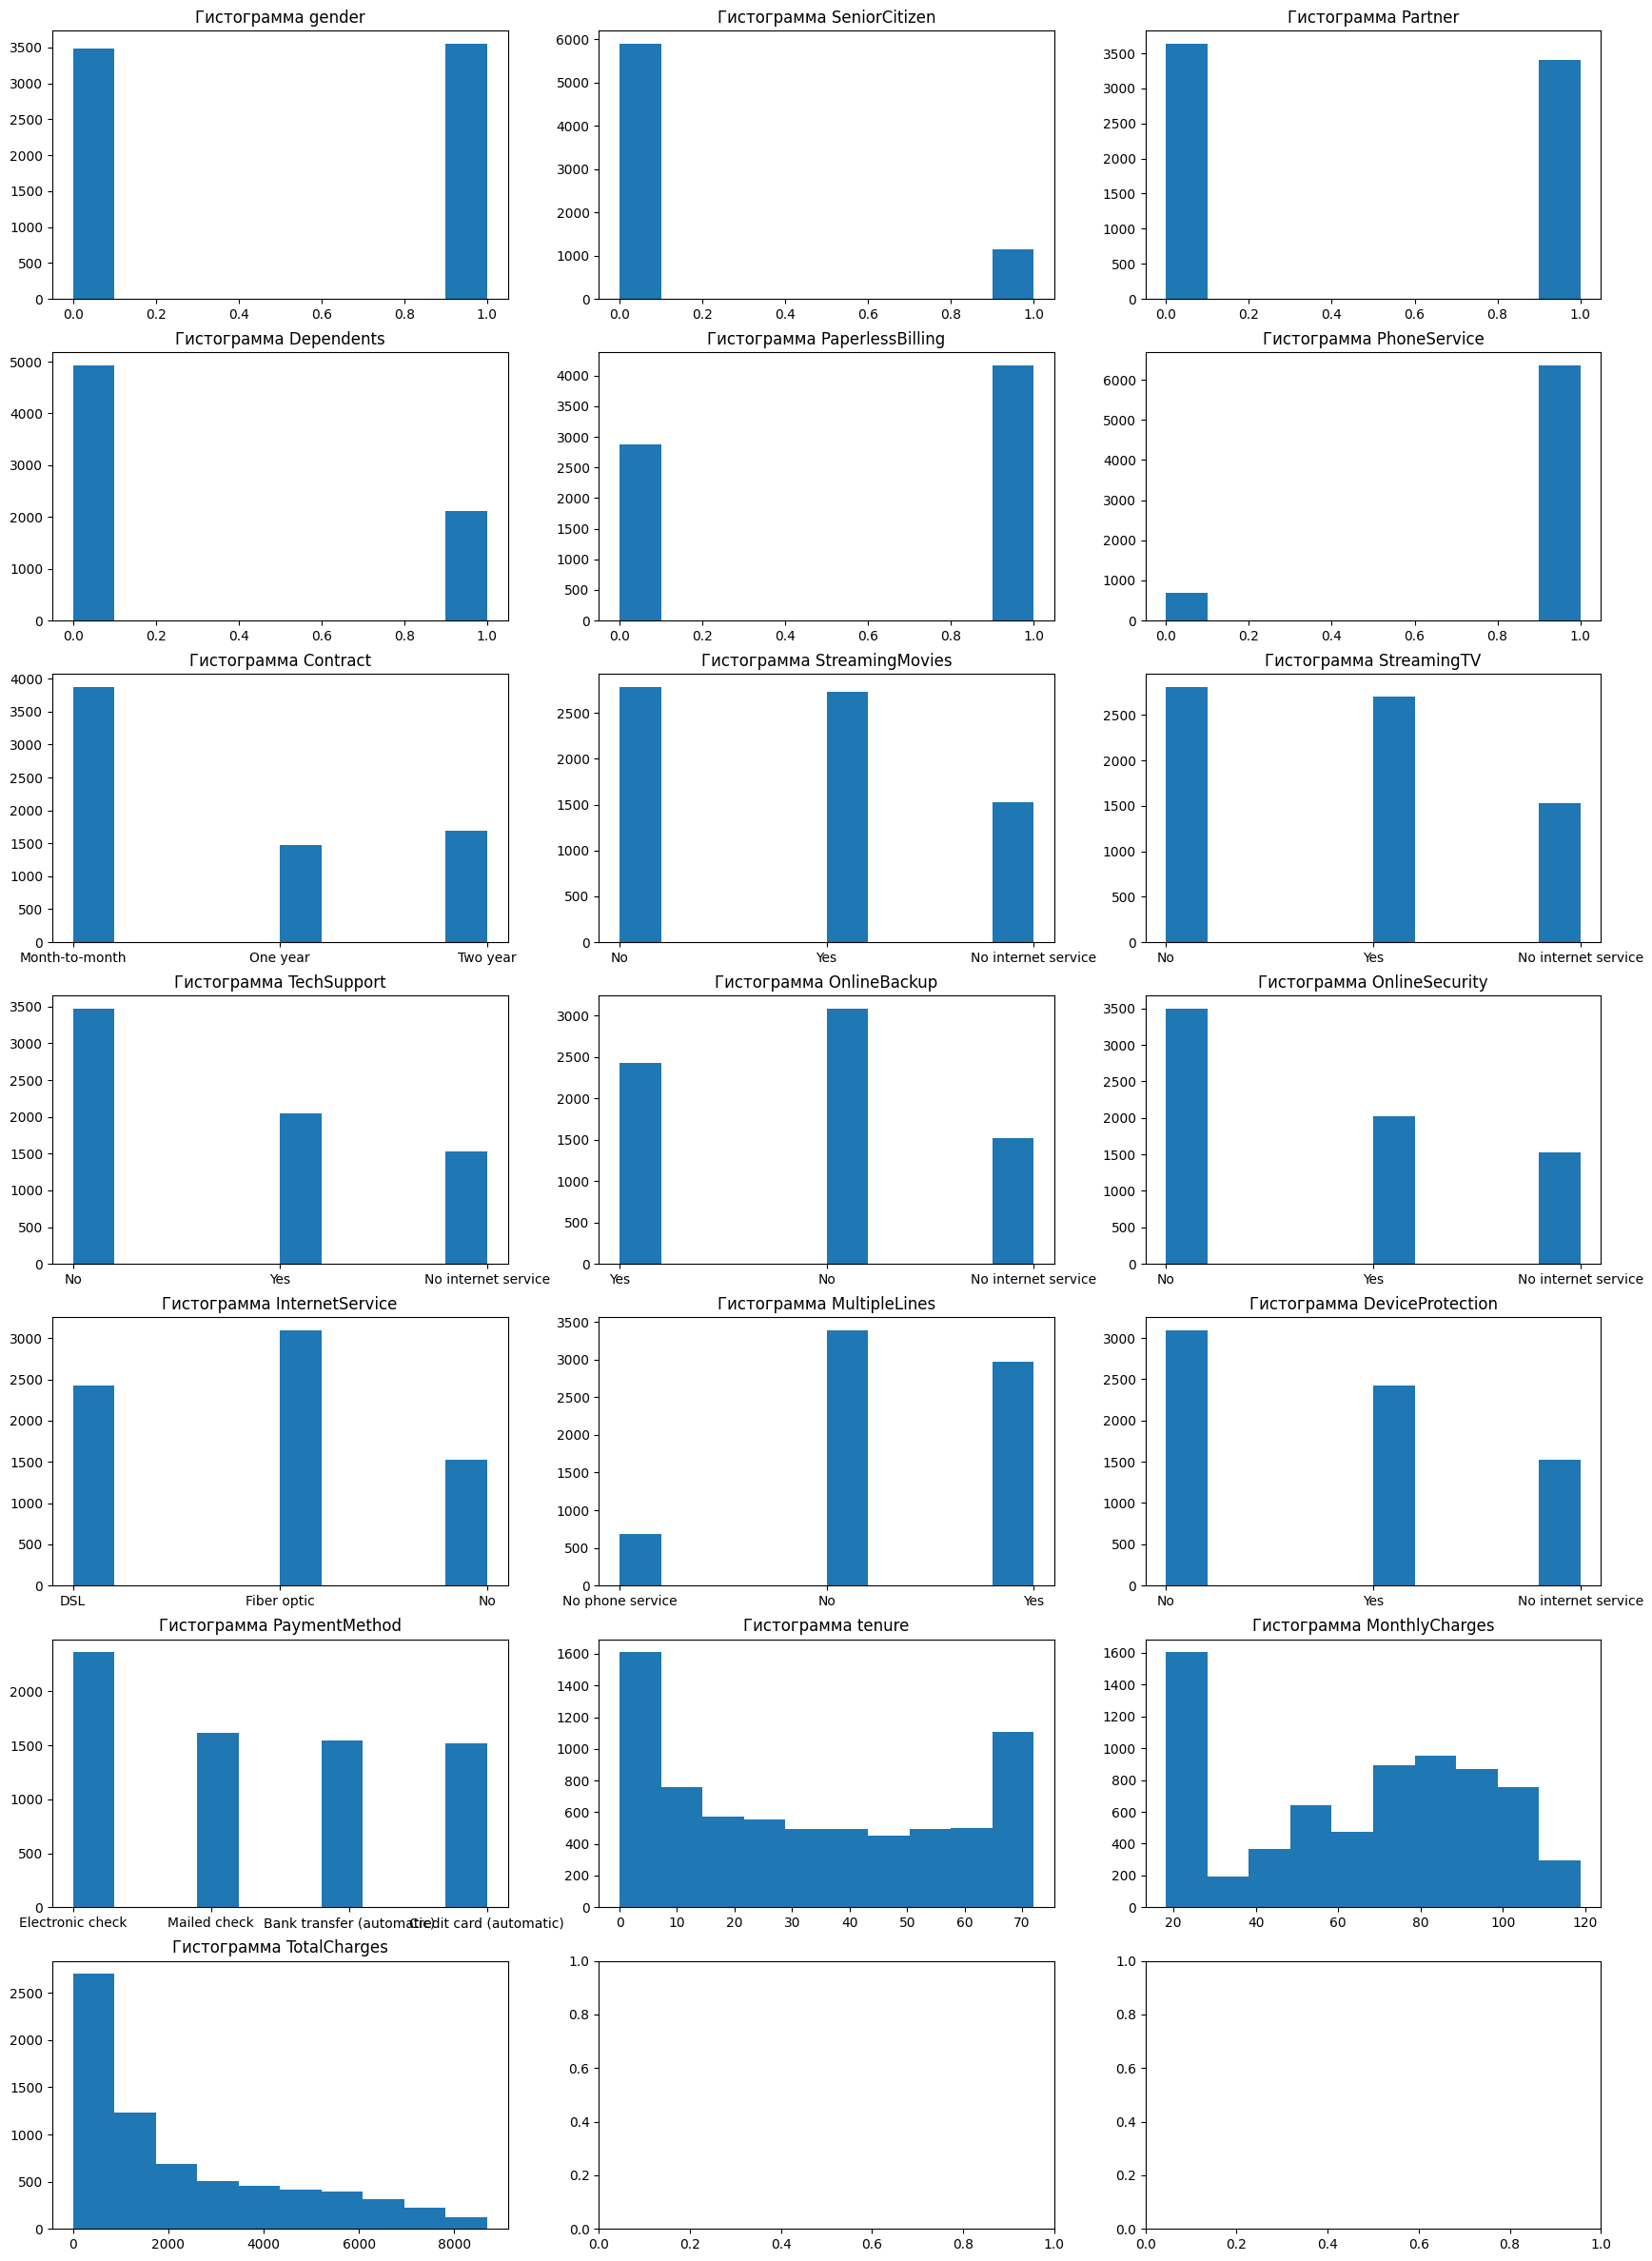

In [14]:
#Визуализируем распределения признаков

cols_to_plot_hist = list(data_status[data_status.col_name!='Churn'].sort_values('unique_values').col_name)
fig, ax = plt.subplots(len(cols_to_plot_hist)//3 + 1, 3, figsize=(21, 30))
for i in range(len(cols_to_plot_hist)):
    col = cols_to_plot_hist[i]
    ax[i//3, i%3].set_title('Гистограмма ' + col)
    ax[i//3, i%3].hist(df[col])#, bins=20)
plt.show()
#В числовых признаках выбросов не вижу. У TotalCharges есть хвост, но не критичный
#В нескольких категориальных признаках есть значения с небольшой долей наблюдений (SeniorCitizen, PhoneService, MultipleLines), но опять же 
#не критично - ничего делать с этим не требуется

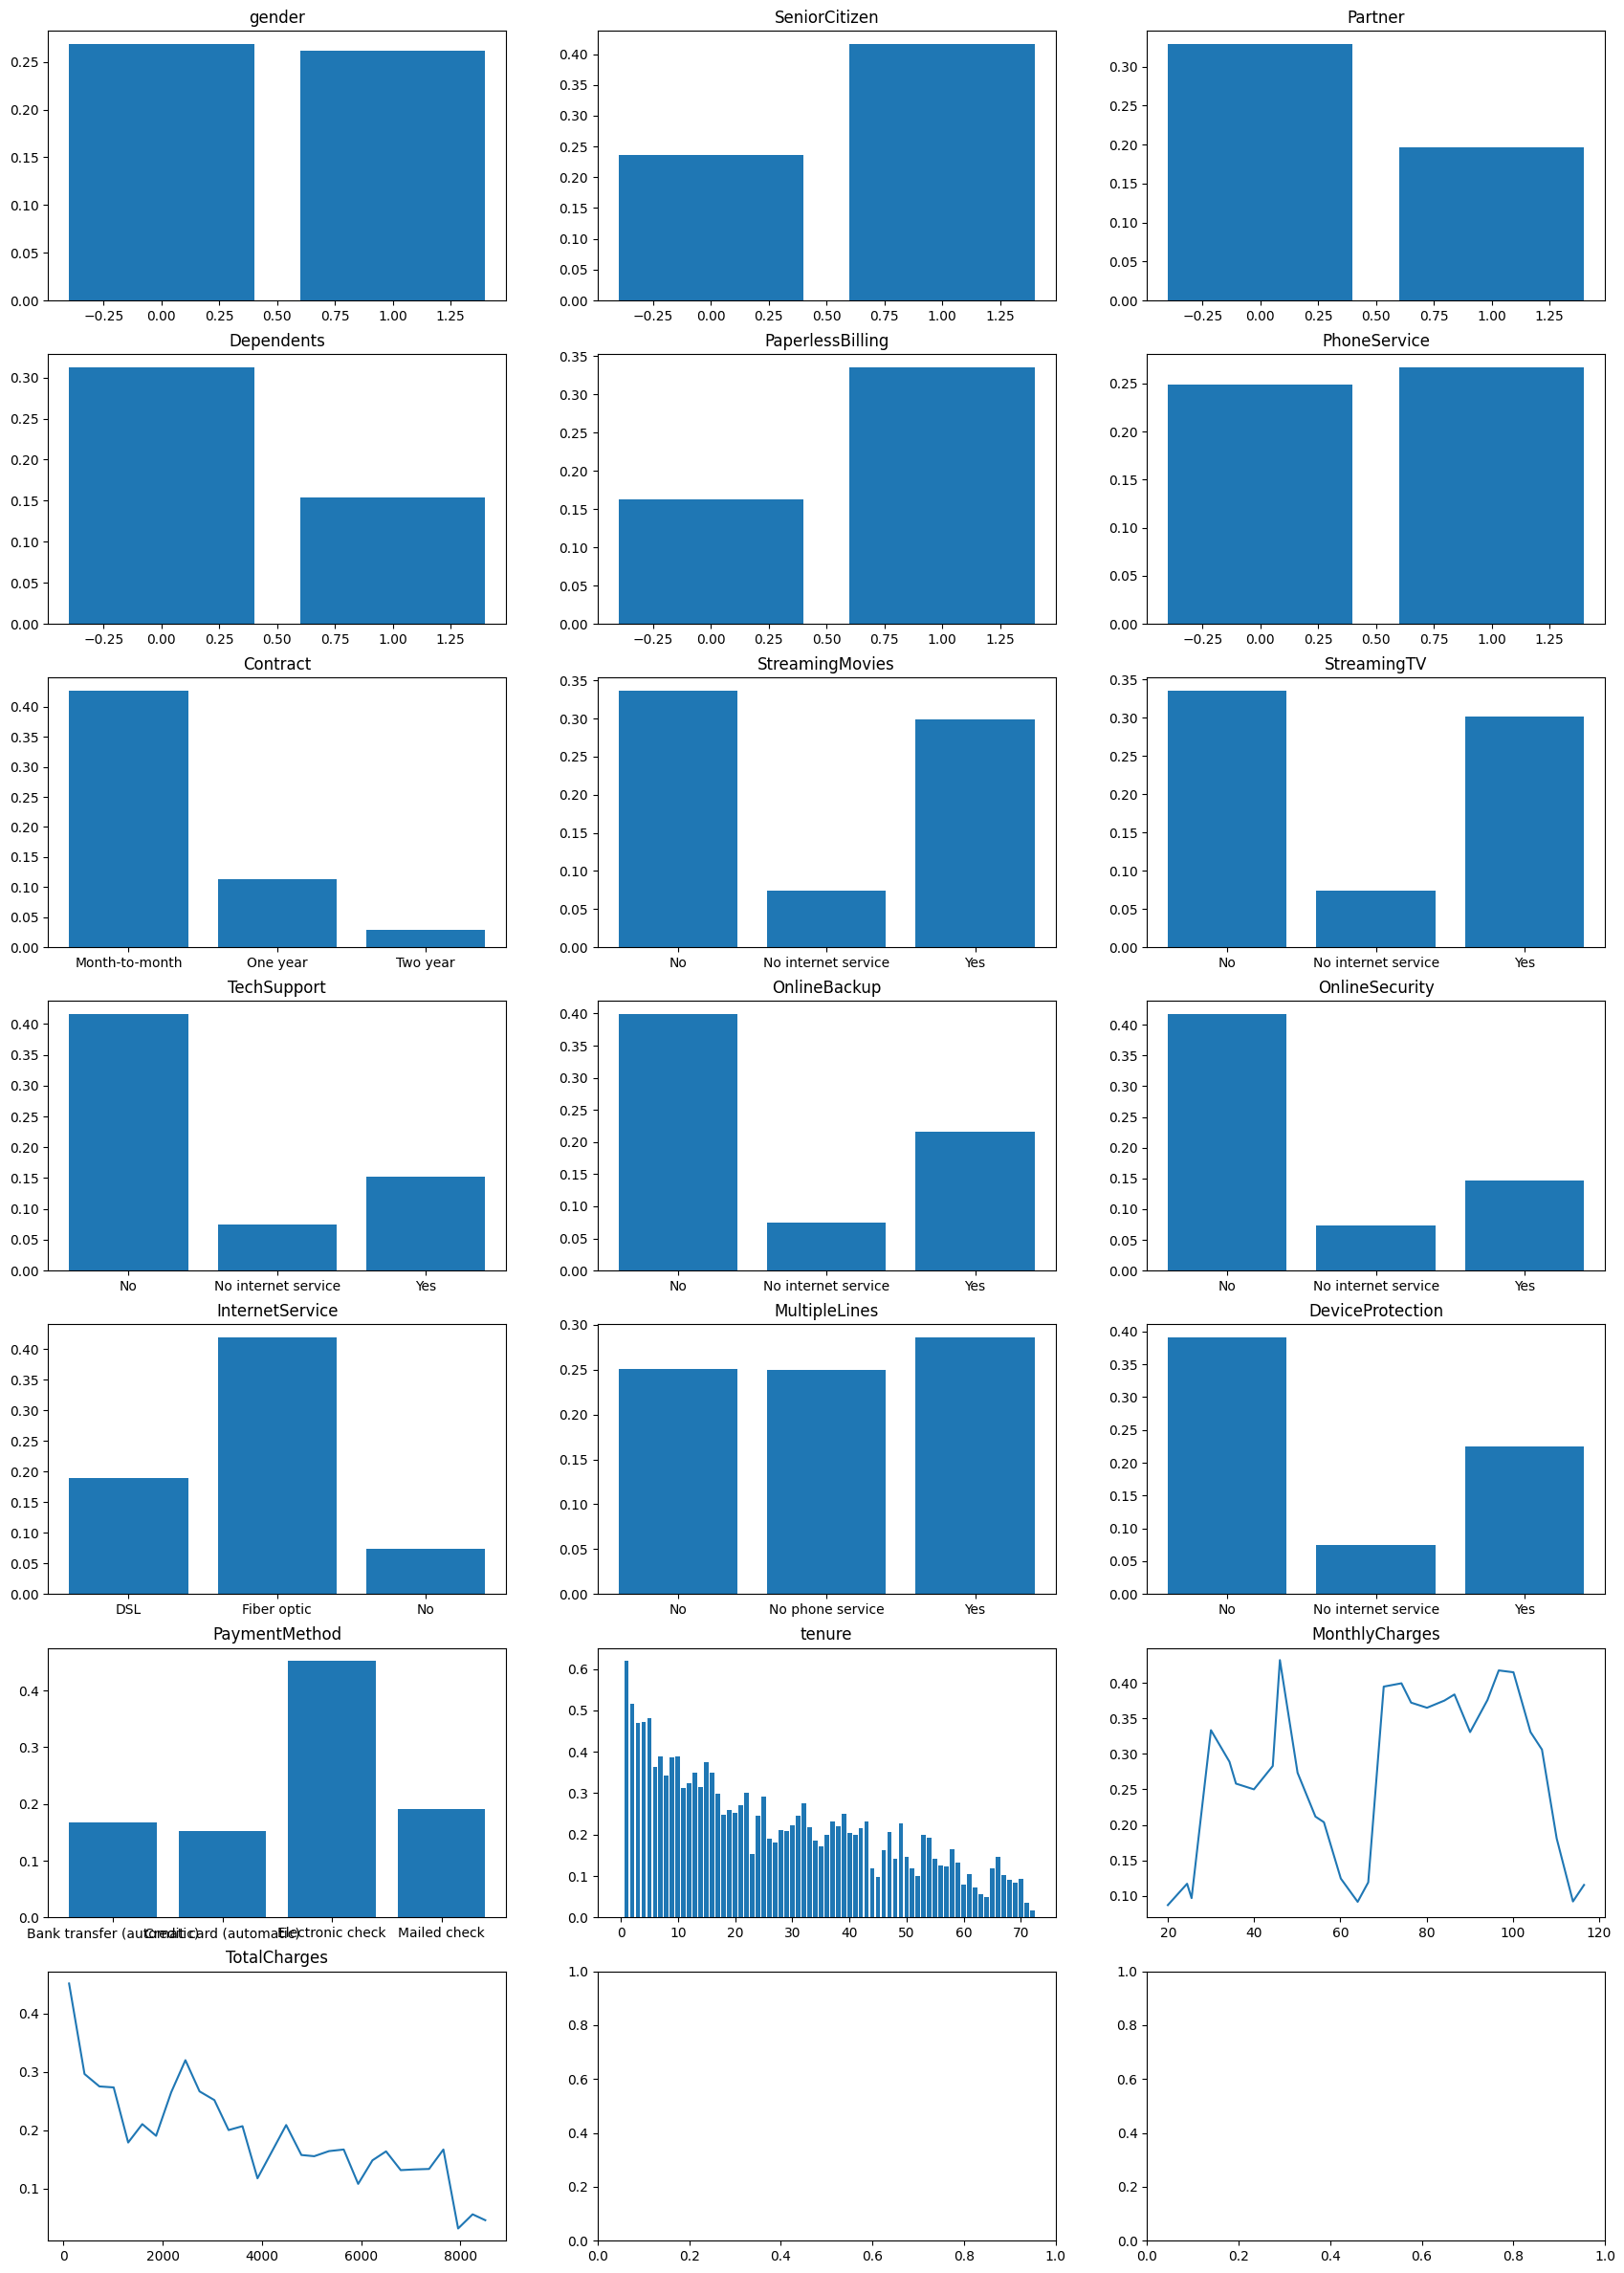

In [15]:
#Посмотрим теперь на графиках зависимость таргета от отдельных признаков
cols_to_plot_target = list(data_status[data_status.col_name!='Churn'].sort_values('unique_values').col_name)

fig, ax = plt.subplots(len(cols_to_plot_target)//3 + 1, 3, figsize=(21, 30))
count = 0
for i in range(len(cols_to_plot_target)):
    col = cols_to_plot_target[i]
    ax[i//3, i%3].set_title(col)
    if data_status[data_status.col_name==col].unique_values.iloc[0] < 100: #В наших данных все, что больше, это числовые признаки с большим кол-вом значений
        df_aux = df[[col, 'Churn']].copy()
        df_aux = df_aux.groupby(col).mean().reset_index()
        ax[i//3, i%3].bar(df_aux[col], df_aux['Churn'])
    else: #случай числовых признаков с большим кол-вом значений
        df_aux = df[[col, 'Churn']].copy()
        df_aux[col+'_bin'] = pd.cut(df_aux[col], bins=30)
        df_aux = df_aux.drop(col, axis=1).merge(df_aux.groupby(col+'_bin')[[col]].mean().reset_index(), how='left', on=col+'_bin').drop(col+'_bin', axis=1)
        df_aux = df_aux.groupby(col).mean().reset_index()
        ax[i//3, i%3].plot(df_aux[col], df_aux['Churn']) #Нет, тут надо по перцентилям разбить
    count+=1
plt.show()

#Многие признаки выглядят неплохо разделяющими целевые классы. 
#Слабая зависимость таргета или ее отсутствие наблюдается от gender, PhoneService, MultipleLines. Однако, удалять их я не буду, потому что в 
#комбинациях с другими признаками они могут нести полезную информацию
#TotalCharges ожидаемо коррелирует с tenure. Судя по описанию, это логично

In [16]:
#Обновим статус по данным
data_status = pd.DataFrame({'col_name': list(df.columns), 'data_type': list(df.dtypes), 'unique_values': list(df.nunique()), 'nan_values': list(df.isna().sum()), 'nan_part': list(np.round(df.isna().mean(), 4))})

In [17]:
#Вообще кодирование категориальных признаков должно происходить на тренировочной выборке, но для конкретно LabelEncoder, который требуется использовать 
#по условию, это необязательно. Так что закодируем сейчас сразу на всей выборке (и сохраним кодирование в словарь для удобства)

cat_cols = list(data_status[data_status.data_type=='object'].col_name)
cat_cols_transform = {}
for col in cat_cols:
    cat_cols_transform[col] = {}
    le = LabelEncoder()
    df[col+'_label'] = le.fit_transform(df[col])
    df_aux = df[[col, col+'_label']].drop_duplicates().sort_values(by=col + '_label').reset_index(drop=True)
    df = df.drop(col, axis=1).rename({col+'_label': col}, axis=1)
    l = df_aux.shape[0]
    for i in range(l):
        cat_cols_transform[col][df_aux[col].iloc[i]] = df_aux[col+'_label'].iloc[i]
cat_cols_transform

{'MultipleLines': {'No': 0, 'No phone service': 1, 'Yes': 2},
 'InternetService': {'DSL': 0, 'Fiber optic': 1, 'No': 2},
 'OnlineSecurity': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'OnlineBackup': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'DeviceProtection': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'TechSupport': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'StreamingTV': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'StreamingMovies': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'Contract': {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
 'PaymentMethod': {'Bank transfer (automatic)': 0,
  'Credit card (automatic)': 1,
  'Electronic check': 2,
  'Mailed check': 3}}

### Построение модели

In [18]:
#Разбиваем выборку на train/test
X = df.drop('Churn', axis=1)
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### Строим модели из коробки

In [19]:
GBC = GradientBoostingClassifier()
GBC.fit(X_train, y_train)

XGBC = XGBClassifier()
XGBC.fit(X_train, y_train)

CBC = CatBoostClassifier(logging_level='Silent')
CBC.fit(X_train, y_train)

LGBMC = LGBMClassifier(verbose=-1)
LGBMC.fit(X_train, y_train)

models = [GBC, XGBC, CBC, LGBMC]
models_dict = {0: 'SK_GB', 1: 'XGBoost', 2: 'CatBoost', 3: 'LightGBM'}

roc_auc_train = []
roc_auc_test = []
for i in range(len(models)):
    y_pred_train_proba = models[i].predict_proba(X_train)[:,1]
    y_pred_test_proba = models[i].predict_proba(X_test)[:,1]
    #y_pred_test_class = np.array([int(y) for y in y_pred_test_proba>threshold]) #Прогноз класса с учетом заданного порога threshold (если захотим посмотреть вышеупомянутые метрики)
    roc_auc_train.append(roc_auc_score(y_train, y_pred_train_proba))
    roc_auc_test.append(roc_auc_score(y_test, y_pred_test_proba))
    print(models_dict[i] + ' roc_auc train: %.3f' %roc_auc_train[i])
    print(models_dict[i] + ' roc_auc test: %.3f\n' %roc_auc_test[i])

SK_GB roc_auc train: 0.880
SK_GB roc_auc test: 0.855

XGBoost roc_auc train: 0.987
XGBoost roc_auc test: 0.838

CatBoost roc_auc train: 0.942
CatBoost roc_auc test: 0.850

LightGBM roc_auc train: 0.954
LightGBM roc_auc test: 0.848



In [20]:
#Пока явного лидера нет: заметно отстает только XGBoost, а GB из sklearn слегка лучше, чем CatBoost и LightGBM (но не факт, что статзначимо)

##### Подбираем гиперпараметры

Поищем с помощью GridSearchCV из sklearn

In [21]:
roc_auc_test_hyper = []

start_time = time.time()

boosting_grid = {
    #'loss': ['log_loss', 'exponential'],
    'n_estimators': [40, 50, 75, 100, 125, 150], #Перебирать learning_rate не буду, потому что этот гиперпараметр связан с кол-вом деревьев
    'max_depth': [1, 2, 3, 4], #Большими делать не буду, потому что для бустинга нужны слабые модели
    'subsample': [0.6, 0.7, 0.8, 0.9]
}
#границы сетки определил в несколько итераций, подробнее - в комментариях в этой же ячейке ниже

cols = [
    #'param_loss',
    'param_n_estimators',
    'param_max_depth',
    'param_subsample',
    'mean_train_score',
    'mean_test_score'
]

for i in range(len(models)):
    start_time_2 = time.time()
    print('Поиск лучших гиперпараметров ' + models_dict[i] + ':')
    search_boosting = GridSearchCV(models[i], boosting_grid, 
                         cv=5, scoring='roc_auc', return_train_score=True)

    search_boosting.fit(X_train, y_train)                                   

    print(search_boosting.best_params_)

    y_pred_test_proba = search_boosting.predict_proba(X_test)[:,1]
    roc_auc_test_hyper.append(roc_auc_score(y_test, y_pred_test_proba))
    print('ROC-AUC на тесте из коробки: %.3f' %roc_auc_test[i])
    print('ROC-AUC на тесте после настройки гиперпараметров: %.3f' %roc_auc_test_hyper[i])

    print('Затрачено времени на модель: %.1f мин\n\n' %((time.time() - start_time_2)/60.0))
    
    #pd.DataFrame(search_boosting.cv_results_).sort_values('rank_test_score')[cols].reset_index(drop=True)
    #С помощью этой матрицы и нескольких предварительных прогонов по сетке убрал некоторые наборы гиперпараметров (например, слишком малое и слишком 
    #большое кол-во деревьев), потому что видно, что они почти всегда дают худшие значения метрик, чем на других наборах гиперпараметров

print('\n\nЗатрачено времени всего: %.1f мин' %((time.time() - start_time)/60.0))
#видно, что лучшие гиперпараметры находятся внутри сетки, а не на ее граничных значениях. Так что раздвигать границы сетки нет смысла, разве 
#что только - дробить

Поиск лучших гиперпараметров SK_GB:
{'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
ROC-AUC на тесте из коробки: 0.855
ROC-AUC на тесте после настройки гиперпараметров: 0.858
Затрачено времени на модель: 10.5 мин


Поиск лучших гиперпараметров XGBoost:
{'max_depth': 1, 'n_estimators': 100, 'subsample': 0.7}
ROC-AUC на тесте из коробки: 0.838
ROC-AUC на тесте после настройки гиперпараметров: 0.859
Затрачено времени на модель: 2.5 мин


Поиск лучших гиперпараметров CatBoost:
{'max_depth': 2, 'n_estimators': 100, 'subsample': 0.9}
ROC-AUC на тесте из коробки: 0.850
ROC-AUC на тесте после настройки гиперпараметров: 0.860
Затрачено времени на модель: 2.4 мин


Поиск лучших гиперпараметров LightGBM:
{'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6}
ROC-AUC на тесте из коробки: 0.848
ROC-AUC на тесте после настройки гиперпараметров: 0.857
Затрачено времени на модель: 2.0 мин




Затрачено времени всего: 17.5 мин


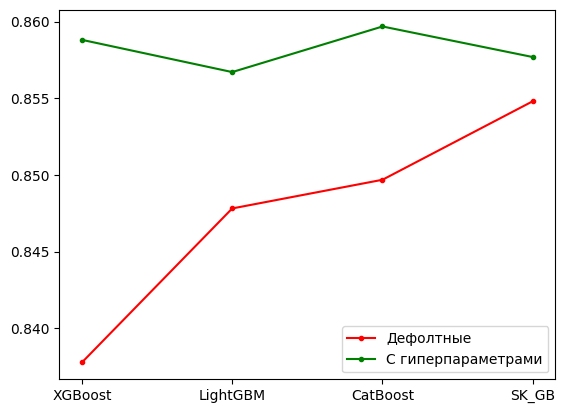

,model,default,hyper,delta
0,XGBoost,0.837765,0.858810,0.021046
1,LightGBM,0.847811,0.856707,0.008896
2,CatBoost,0.849683,0.859681,0.009998
3,SK_GB,0.854806,0.857687,0.002881


In [22]:
#Отрисуем ROC-AUC и его изменение после поиска гиперпараметров для моделей
result_df = pd.DataFrame({'model': list(models_dict.values()), 
              'default': roc_auc_test, 'hyper': roc_auc_test_hyper, 
              'delta': np.array(roc_auc_test_hyper) - np.array(roc_auc_test)})
result_df = result_df.sort_values(by='default').reset_index(drop=True) #Чтобы отрисовать в порядке возрастания дефолтных моделей для наглядности

fig, ax = plt.subplots()
ax.plot(result_df['model'], result_df['default'], marker = '.', color='red', label='Дефолтные')
ax.plot(result_df['model'], result_df['hyper'], marker = '.', color='green', label='С гиперпараметрами')
ax.legend()
plt.show()

result_df

In [23]:
#GB из sklearn почти не изменился, а остальные подросли ощутимо: CatBoost и LightGBM - почти на 0.01, а XGBoost - аж на 0.02. Но наибольший скор
#в итоге у CatBoost. Но это все номинально: отличия между моделями незначительны - можно сказать, что они одинакового качества

Попробуем теперь поискать с помощью optuna

In [24]:
import optuna

optuna.logging.disable_default_handler()

In [25]:
#Определим целевые функции для оптимизации разных моделей (пишу каждую отдельно, потому что не знаю, как корректно обернуть это в цикл)
#И немного расширим область рассматриваемых гиперпараметров: оптуна позволяет это сделать без существенных потерь во времени
def objective_gbc(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 40, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }

    model = GradientBoostingClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, 
        X_train, 
        y_train, 
        cv=cv, 
        scoring='roc_auc',
        n_jobs=-1  # Используем все ядра процессора
    )
    return scores.mean()

def objective_xgbc(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 40, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }

    model = XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, 
        X_train, 
        y_train, 
        cv=cv, 
        scoring='roc_auc',
        n_jobs=-1  # Используем все ядра процессора
    )
    return scores.mean()

def objective_cbc(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 40, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }

    model = CatBoostClassifier(**params, logging_level='Silent')

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, 
        X_train, 
        y_train, 
        cv=cv, 
        scoring='roc_auc',
        n_jobs=-1  # Используем все ядра процессора
    )
    return scores.mean()

def objective_lgbmc(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 40, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }

    model = LGBMClassifier(**params, verbose=-1)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, 
        X_train, 
        y_train, 
        cv=cv, 
        scoring='roc_auc',
        n_jobs=-1  # Используем все ядра процессора
    )
    return scores.mean()

In [26]:
#Применяем оптуну
start_time = time.time()

roc_auc_test_optuna = []

start_time_2 = time.time()
print('Поиск лучших гиперпараметров SK_GB:')
study = optuna.create_study(
    direction='maximize',      # Максимизируем ROC-AUC
    study_name='sk_gb_optuna',
    sampler=optuna.samplers.TPESampler(seed=42) #Можно поиграться с методами оптимизации
)
study.optimize(objective_gbc, n_trials=30)
print("Лучшие гиперпараметры по оптуне:", study.best_params)
best_model = GradientBoostingClassifier(**study.best_params)
best_model.fit(X_train, y_train)
y_pred_test_proba = best_model.predict_proba(X_test)[:,1]
roc_auc_test_optuna.append(roc_auc_score(y_test, y_pred_test_proba))
print('ROC-AUC на тесте по gridsearch: %.3f' %roc_auc_test_hyper[0])
print('ROC-AUC на тесте по optuna: %.3f' %roc_auc_test_optuna[0])
print('Затрачено времени на модель: %.1f мин\n' %((time.time() - start_time_2)/60.0))

start_time_2 = time.time()
print('Поиск лучших гиперпараметров XGBoost:')
study = optuna.create_study(
    direction='maximize',     
    study_name='xgbc_optuna',
    sampler=optuna.samplers.TPESampler(seed=42) 
)
study.optimize(objective_xgbc, n_trials=30)
print("Лучшие гиперпараметры по оптуне:", study.best_params)
best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)
y_pred_test_proba = best_model.predict_proba(X_test)[:,1]
roc_auc_test_optuna.append(roc_auc_score(y_test, y_pred_test_proba))
print('ROC-AUC на тесте по gridsearch: %.3f' %roc_auc_test_hyper[1])
print('ROC-AUC на тесте по optuna: %.3f' %roc_auc_test_optuna[1])
print('Затрачено времени на модель: %.1f мин\n' %((time.time() - start_time_2)/60.0))

start_time_2 = time.time()
print('Поиск лучших гиперпараметров CatBoost:')
study = optuna.create_study(
    direction='maximize',    
    study_name='cbc_optuna',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective_cbc, n_trials=30)
print("Лучшие гиперпараметры по оптуне:", study.best_params)
best_model = CatBoostClassifier(**study.best_params, logging_level='Silent')
best_model.fit(X_train, y_train)
y_pred_test_proba = best_model.predict_proba(X_test)[:,1]
roc_auc_test_optuna.append(roc_auc_score(y_test, y_pred_test_proba))
print('ROC-AUC на тесте по gridsearch: %.3f' %roc_auc_test_hyper[2])
print('ROC-AUC на тесте по optuna: %.3f' %roc_auc_test_optuna[2])
print('Затрачено времени на модель: %.1f мин\n' %((time.time() - start_time_2)/60.0))

start_time_2 = time.time()
print('Поиск лучших гиперпараметров LightGBM:')
study = optuna.create_study(
    direction='maximize',   
    study_name='lgbmc_optuna',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective_lgbmc, n_trials=30)
print("Лучшие гиперпараметры по оптуне:", study.best_params)
best_model = LGBMClassifier(**study.best_params, verbose=-1)
best_model.fit(X_train, y_train)
y_pred_test_proba = best_model.predict_proba(X_test)[:,1]
roc_auc_test_optuna.append(roc_auc_score(y_test, y_pred_test_proba))
print('ROC-AUC на тесте по gridsearch: %.3f' %roc_auc_test_hyper[3])
print('ROC-AUC на тесте по optuna: %.3f' %roc_auc_test_optuna[3])
print('Затрачено времени на модель: %.1f мин\n' %((time.time() - start_time_2)/60.0))

print('\nЗатрачено времени всего: %.1f мин' %((time.time() - start_time)/60.0))

Поиск лучших гиперпараметров SK_GB:
Лучшие гиперпараметры по оптуне: {'n_estimators': 366, 'max_depth': 1, 'subsample': 0.9849549260809971}
ROC-AUC на тесте по gridsearch: 0.858
ROC-AUC на тесте по optuna: 0.861
Затрачено времени на модель: 2.8 мин

Поиск лучших гиперпараметров XGBoost:
Лучшие гиперпараметры по оптуне: {'n_estimators': 291, 'max_depth': 1, 'subsample': 0.997940938325986}
ROC-AUC на тесте по gridsearch: 0.859
ROC-AUC на тесте по optuna: 0.859
Затрачено времени на модель: 0.3 мин

Поиск лучших гиперпараметров CatBoost:
Лучшие гиперпараметры по оптуне: {'n_estimators': 395, 'max_depth': 2, 'subsample': 0.5617726786995088}
ROC-AUC на тесте по gridsearch: 0.860
ROC-AUC на тесте по optuna: 0.860
Затрачено времени на модель: 1.2 мин

Поиск лучших гиперпараметров LightGBM:
Лучшие гиперпараметры по оптуне: {'n_estimators': 383, 'max_depth': 1, 'subsample': 0.9913944022068961}
ROC-AUC на тесте по gridsearch: 0.857
ROC-AUC на тесте по optuna: 0.860
Затрачено времени на модель: 1.

In [27]:
#Видим, что в первом приближении оптуна не дала значимого прироста качества относительно гридсёрча, так что отрисовывать новый график нет смысла
#Возможно, более скурпулезные настройки в оптуне могут дать лучший результат, но остановимся на этом
#При этом хочу отметить два нюанса:
#1. Оптуна нашла гиперпараметры, дающие такое же качество, но всего за 30 попыток - в три раза быстрее. Я пробовал и n_trials=96 для честного сравнения 
#с гридсёрчем (ведь он перебирал 96 наборов), но лучше качество от этого не стало
#2. Однако, видно, что оптуна выдала в качестве лучших гиперпараметров гораздо большее количество деревьев, чем нашел gridsearch. А при одинаковом 
#качестве я предпочту модель с меньшим количеством деревьев: вычислительно она более эффективна. Так что в качестве итогового набора гиперпараметров
#я выберу результат gridsearch

In [48]:
#В итоге я буду использовать модель CatBoostClassifier(max_depth=2, n_estimators=100, subsample=0.9, logging_level='Silent')

#### Изучим полученную модель, посмотрим на результаты

Проверим важность признаков с помощью feature_importances_

ROC-AUC на тесте: 0.860


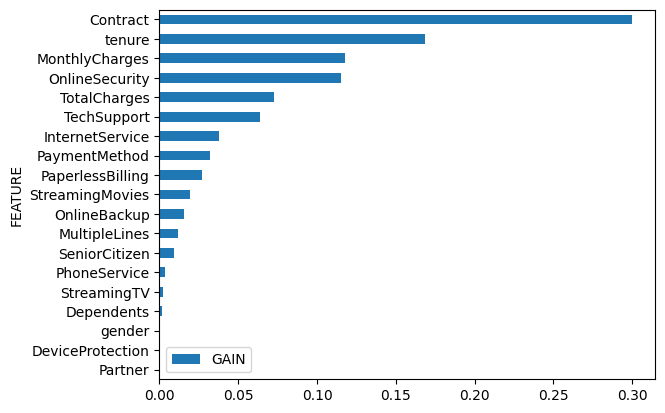

In [28]:
final_model = CatBoostClassifier(max_depth=2, n_estimators=100, subsample=0.9, logging_level='Silent')
final_model.fit(X_train, y_train)

y_pred_test_proba = final_model.predict_proba(X_test)[:,1]
print('ROC-AUC на тесте: %.3f' %roc_auc_score(y_test, y_pred_test_proba))

feature_importances = final_model.feature_importances_
feature_importances = feature_importances/feature_importances.sum()
feature_names = list(X_train.columns)
gain_importance = pd.DataFrame({'FEATURE': feature_names, 'GAIN': feature_importances})
gain_importance = gain_importance.sort_values(by='GAIN')

gain_importance.plot.barh(x='FEATURE', y='GAIN')
plt.show()
#Видим, что есть набор несущественных признаков - удалим их

In [29]:
list(gain_importance[gain_importance.GAIN<0.02].FEATURE)

['Partner',
 'DeviceProtection',
 'gender',
 'Dependents',
 'StreamingTV',
 'PhoneService',
 'SeniorCitizen',
 'MultipleLines',
 'OnlineBackup',
 'StreamingMovies']

In [30]:
#Уберем малоинформативные признаки и перепроверим качество модели
important_feature = list(gain_importance[gain_importance.GAIN>=0.02].FEATURE)
#взял такой порог, потому что он отсекает половину признаков, а потери в 
#ROC-AUC практически не дает (0.002 - незначительная разница)

X_train_cut = X_train[important_feature]
X_test_cut = X_test[important_feature]
final_model = CatBoostClassifier(max_depth=2, n_estimators=100, subsample=0.9, logging_level='Silent')
final_model.fit(X_train_cut, y_train)

y_pred_test_proba = final_model.predict_proba(X_test_cut)[:,1]
print('ROC-AUC на тесте: %.3f' %roc_auc_score(y_test, y_pred_test_proba))
#Качество уменьшилось несущественно: на 0.002. Ради этого можно удалить большую часть признаков: чем их меньше при сохранении качества, тем лучше

ROC-AUC на тесте: 0.858


Перейдем теперь к рассмотрению других метрик классификации

In [32]:
#Зададим стандартный порог прогнозирования положительного класса, но при желании изменить метрики precision, recall, f1-score и accuracy его можно
#поварьировать
threshold = 0.5
y_pred_test_class = np.array([int(class_pred) for class_pred in (y_pred_test_proba > threshold)])

In [33]:
print(classification_report(y_test, y_pred_test_class))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1539
           1       0.69      0.52      0.59       574

    accuracy                           0.81      2113
   macro avg       0.76      0.71      0.73      2113
weighted avg       0.80      0.81      0.80      2113



In [34]:
#Получен неплохой accuracy = 0.81. Что больше, чем у константной модели, прогнозирующей наиболее частый класс, то есть 0. В данном случае, т.к.
#0 составляет 73% в выборке, у такой модели accuracy был бы равен 0.73
#precision, recall и f1-score на положительном классе выглядят не очень хорошими, однако, существенно лучше чем у случайного классификатора или чем у
#вышеупомянутого константного

In [35]:
#Посмотрим далее на PR-кривую и PR-AUC

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test_proba)
close_threshold = np.argmin(np.abs(thresholds - threshold))

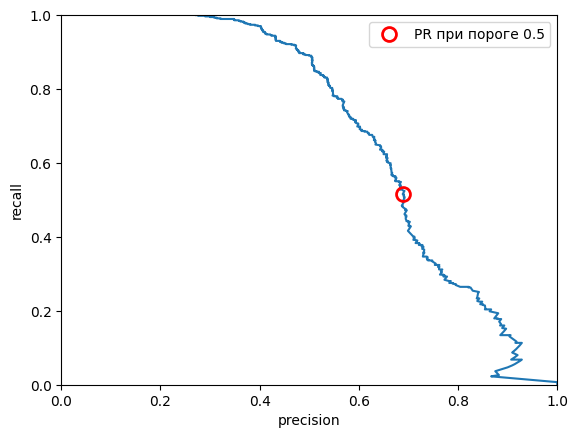

PR-AUC на тесте: 0.688


In [38]:
fig, ax = plt.subplots()
ax.plot(precision, recall)
ax.plot(precision[close_threshold], recall[close_threshold], 'ro', fillstyle='none', markersize=10, mew=2, label='PR при пороге 0.5')
ax.set_xlabel('precision')
ax.set_ylabel('recall')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
plt.show()

print('PR-AUC на тесте: %.3f' %auc(recall, precision))

In [ ]:
#Данная кривая показывает, какую пару (precision, recall) мы можем получить, варьируя порог предсказания
#Сам PR-AUC значительно лучше, чем у случайного классификатора, который выдает PR-AUC, равный доле миноритарного класса, т.е. 0.27

In [39]:
#На всякий случай убедимся в том, что PR-AUC случайного классификатора выдает долю миноритарного класса
y_test_pred_random = np.random.uniform(0, 1, size=len(y_test))
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_random)
print('PR-AUC на тесте: %.3f' %auc(recall, precision))

PR-AUC на тесте: 0.281


### Дополнительное исследование
#### Попробуем как-нибудь улучшить качество модели

Попробуем сначала при подборе гиперпараметров ориентироваться не на ROC-AUC, а на f1-score - с целью улучшить precision, recall и f1-меру

In [41]:
#Попробуем ориентироваться на f1-score

#Не буду использовать оптуну, чтобы не переписывать функции objective под f1_score - сделаю по старинке, через gridsearch

GBC = GradientBoostingClassifier()
XGBC = XGBClassifier()
CBC = CatBoostClassifier(logging_level='Silent')
LGBMC = LGBMClassifier(verbose=-1)
models = [GBC, XGBC, CBC, LGBMC]
models_dict = {0: 'SK_GB', 1: 'XGBoost', 2: 'CatBoost', 3: 'LightGBM'}

roc_auc_test_hyper = []
f1_score_test_hyper = []

start_time = time.time()


boosting_grid = {
    'n_estimators': [40, 50, 75, 100, 125, 150], #Перебирать learning_rate не буду, потому что этот гиперпараметр связан с кол-вом деревьев
    'max_depth': [1, 2, 3, 4], #Большими делать не буду, потому что для бустинга нужны слабые модели
    'subsample': [0.6, 0.7, 0.8, 0.9]
}

cols = [
    #'param_loss',
    'param_n_estimators',
    'param_max_depth',
    'param_subsample',
    'mean_train_score',
    'mean_test_score'
]

for i in range(len(models)):
    start_time_2 = time.time()
    print('Поиск лучших гиперпараметров ' + models_dict[i] + ':')
    search_boosting = GridSearchCV(models[i], boosting_grid, 
                         cv=5, scoring='f1', return_train_score=True)

    search_boosting.fit(X_train, y_train)                                   

    print(search_boosting.best_params_)

    y_pred_test_proba = search_boosting.predict_proba(X_test)[:,1]
    y_pred_test_class = search_boosting.predict(X_test)
    f1_score_test_hyper.append(f1_score(y_test, y_pred_test_class))
    roc_auc_test_hyper.append(roc_auc_score(y_test, y_pred_test_proba))
    print('f1 на тесте после настройки гиперпараметров: %.3f' %f1_score_test_hyper[i])
    print('ROC-AUC на тесте после настройки гиперпараметров: %.3f' %roc_auc_test_hyper[i])

    print('Затрачено времени на модель: %.1f мин\n\n' %((time.time() - start_time_2)/60.0))
    #pd.DataFrame(search_boosting.cv_results_).sort_values('rank_test_score')[cols].reset_index(drop=True)
    #С помощью этой матрицы и нескольких предварительных прогонов по сетке убрал некоторые наборы гиперпараметров (например, слишком малое и слишком 
    #большое кол-во деревьев), потому что видно, что они почти всегда дают худшие значения метрик, чем на других наборах гиперпараметров

print('\n\nЗатрачено времени всего: %.1f мин' %((time.time() - start_time)/60.0))

Поиск лучших гиперпараметров SK_GB:
{'max_depth': 4, 'n_estimators': 50, 'subsample': 0.6}
f1 на тесте после настройки гиперпараметров: 0.589
ROC-AUC на тесте после настройки гиперпараметров: 0.860
Затрачено времени на модель: 6.1 мин


Поиск лучших гиперпараметров XGBoost:
{'max_depth': 1, 'n_estimators': 100, 'subsample': 0.8}
f1 на тесте после настройки гиперпараметров: 0.591
ROC-AUC на тесте после настройки гиперпараметров: 0.860
Затрачено времени на модель: 2.5 мин


Поиск лучших гиперпараметров CatBoost:
{'max_depth': 2, 'n_estimators': 40, 'subsample': 0.9}
f1 на тесте после настройки гиперпараметров: 0.601
ROC-AUC на тесте после настройки гиперпараметров: 0.859
Затрачено времени на модель: 2.5 мин


Поиск лучших гиперпараметров LightGBM:
{'max_depth': 2, 'n_estimators': 150, 'subsample': 0.6}
f1 на тесте после настройки гиперпараметров: 0.587
ROC-AUC на тесте после настройки гиперпараметров: 0.857
Затрачено времени на модель: 2.0 мин




Затрачено времени всего: 13.1 мин


In [42]:
#К сожалению, видно, что f1-мера лучше не становится. Тогда ожидать улучшения precision и recall тоже не приходится

Попробуем oversampling, чтобы поправить дисбаланс классов. Проведу его, однократно продублировав каждое наблюдение миноритарного класса на трейне. Так соотношение примерно 2/3, а не 1/1. Но излишнее замножение наблюдений может привести к переобучению. А если оно хоть как-то нам может помочь, на 2/3 это уже должно быть заметно. Так что хотя бы начнем с этого

In [43]:
#Важно продублировать наблюдения миноритарного класса именно на трейне

X_train_aux = X_train.copy()
X_train_aux['Churn'] = y_train
X_train_aux = pd.concat([X_train_aux, X_train_aux[X_train_aux.Churn==1]])

X_train = X_train_aux.drop('Churn', axis=1)
y_train = X_train_aux.Churn

del X_train_aux

In [44]:
start_time = time.time()

roc_auc_test_optuna = []

start_time_2 = time.time()
print('Поиск лучших гиперпараметров SK_GB:')
study = optuna.create_study(
    direction='maximize',      # Максимизируем ROC-AUC
    study_name='sk_gb_optuna',
    sampler=optuna.samplers.TPESampler(seed=42) #Можно поиграться с методами оптимизации
)
study.optimize(objective_gbc, n_trials=30)
print("Лучшие гиперпараметры по оптуне:", study.best_params)
best_model = GradientBoostingClassifier(**study.best_params)
best_model.fit(X_train, y_train)
y_pred_test_proba = best_model.predict_proba(X_test)[:,1]
roc_auc_test_optuna.append(roc_auc_score(y_test, y_pred_test_proba))
print('ROC-AUC на тесте по optuna: %.3f' %roc_auc_test_optuna[0])
print('Затрачено времени на модель: %.1f мин\n' %((time.time() - start_time_2)/60.0))

start_time_2 = time.time()
print('Поиск лучших гиперпараметров XGBoost:')
study = optuna.create_study(
    direction='maximize',     
    study_name='xgbc_optuna',
    sampler=optuna.samplers.TPESampler(seed=42) 
)
study.optimize(objective_xgbc, n_trials=30)
print("Лучшие гиперпараметры по оптуне:", study.best_params)
best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)
y_pred_test_proba = best_model.predict_proba(X_test)[:,1]
roc_auc_test_optuna.append(roc_auc_score(y_test, y_pred_test_proba))
print('ROC-AUC на тесте по optuna: %.3f' %roc_auc_test_optuna[1])
print('Затрачено времени на модель: %.1f мин\n' %((time.time() - start_time_2)/60.0))

start_time_2 = time.time()
print('Поиск лучших гиперпараметров CatBoost:')
study = optuna.create_study(
    direction='maximize',    
    study_name='cbc_optuna',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective_cbc, n_trials=30)
print("Лучшие гиперпараметры по оптуне:", study.best_params)
best_model = CatBoostClassifier(**study.best_params, logging_level='Silent')
best_model.fit(X_train, y_train)
y_pred_test_proba = best_model.predict_proba(X_test)[:,1]
roc_auc_test_optuna.append(roc_auc_score(y_test, y_pred_test_proba))
print('ROC-AUC на тесте по optuna: %.3f' %roc_auc_test_optuna[2])
print('Затрачено времени на модель: %.1f мин\n' %((time.time() - start_time_2)/60.0))

start_time_2 = time.time()
print('Поиск лучших гиперпараметров LightGBM:')
study = optuna.create_study(
    direction='maximize',   
    study_name='lgbmc_optuna',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective_lgbmc, n_trials=30)
print("Лучшие гиперпараметры по оптуне:", study.best_params)
best_model = LGBMClassifier(**study.best_params, verbose=-1)
best_model.fit(X_train, y_train)
y_pred_test_proba = best_model.predict_proba(X_test)[:,1]
roc_auc_test_optuna.append(roc_auc_score(y_test, y_pred_test_proba))
print('ROC-AUC на тесте по optuna: %.3f' %roc_auc_test_optuna[3])
print('Затрачено времени на модель: %.1f мин\n' %((time.time() - start_time_2)/60.0))

print('\nЗатрачено времени всего: %.1f мин' %((time.time() - start_time)/60.0))

Поиск лучших гиперпараметров SK_GB:
Лучшие гиперпараметры по оптуне: {'n_estimators': 493, 'max_depth': 9, 'subsample': 0.9965295925771572}
ROC-AUC на тесте по optuna: 0.823
Затрачено времени на модель: 9.0 мин

Поиск лучших гиперпараметров XGBoost:
Лучшие гиперпараметры по оптуне: {'n_estimators': 212, 'max_depth': 10, 'subsample': 0.8659969709057025}
ROC-AUC на тесте по optuna: 0.812
Затрачено времени на модель: 0.5 мин

Поиск лучших гиперпараметров CatBoost:
Лучшие гиперпараметры по оптуне: {'n_estimators': 475, 'max_depth': 10, 'subsample': 0.8539268018607309}
ROC-AUC на тесте по optuna: 0.836
Затрачено времени на модель: 5.2 мин

Поиск лучших гиперпараметров LightGBM:
Лучшие гиперпараметры по оптуне: {'n_estimators': 460, 'max_depth': 10, 'subsample': 0.6271641836327536}
ROC-AUC на тесте по optuna: 0.833
Затрачено времени на модель: 6.2 мин


Затрачено времени всего: 20.8 мин


In [45]:
#Снова удаляем малозначимые признаки

final_model = CatBoostClassifier(max_depth=10, n_estimators=475, subsample=0.854, logging_level='Silent')
final_model.fit(X_train, y_train)

y_pred_test_proba = final_model.predict_proba(X_test)[:,1]
print('ROC-AUC на тесте: %.3f' %roc_auc_score(y_test, y_pred_test_proba))

feature_importances = final_model.feature_importances_
feature_importances = feature_importances/feature_importances.sum()
feature_names = list(X_train.columns)
gain_importance = pd.DataFrame({'FEATURE': feature_names, 'GAIN': feature_importances})
gain_importance = gain_importance.sort_values(by='GAIN')

important_feature = list(gain_importance[gain_importance.GAIN>=0.02].FEATURE) 

ROC-AUC на тесте: 0.835


In [46]:
X_train_cut = X_train[important_feature]
X_test_cut = X_test[important_feature]
#final_model = CatBoostClassifier(max_depth=2, n_estimators=100, subsample=0.9, logging_level='Silent')
final_model = CatBoostClassifier(max_depth=10, n_estimators=475, subsample=0.854, logging_level='Silent')
final_model.fit(X_train_cut, y_train)

y_pred_test_proba = final_model.predict_proba(X_test_cut)[:,1]
print('ROC-AUC на тесте: %.3f' %roc_auc_score(y_test, y_pred_test_proba))

ROC-AUC на тесте: 0.832


In [47]:
threshold = 0.5
y_pred_test_class = np.array([int(class_pred) for class_pred in (y_pred_test_proba > threshold)])
print(classification_report(y_test, y_pred_test_class))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1539
           1       0.59      0.61      0.60       574

    accuracy                           0.78      2113
   macro avg       0.72      0.73      0.72      2113
weighted avg       0.78      0.78      0.78      2113

